# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

## Libraries and Dependencies

In [2]:
import sys
sys.path.insert(0, '../Utilities/')

#from neuralop.layers.fno_block import FNOBlocks
import torch
from collections import OrderedDict
import numpy as np
import re
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings('ignore')

# Set default dtype for PyTorch (recommended for new code)
torch.set_default_dtype(torch.float32)

# For reproducibility
np.random.seed(1234)
torch.manual_seed(1234)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1234)

In [3]:
# Modern device selection for PyTorch with MPS (Apple Silicon/Metal Performance Shaders)
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
print(f"Using device: {device}")

Using device: mps


## Physics-informed Neural Networks

In [5]:
# the deep neural network
class DNN(torch.nn.Module):

    def __init__(self, layers: list[int]):
        super().__init__()
        self.depth = len(layers) - 1
        self.activation = torch.nn.LeakyReLU
        layer_list = []
        for i in range(self.depth - 1):
            layer_list.append((
                f'layer_{i}', torch.nn.Linear(layers[i], layers[i+1])
            ))
            layer_list.append((f'activation_{i}', self.activation()))
            layer_list.append((f'dropout_{i}', torch.nn.Dropout(p=0.05)))
        layer_list.append((
            f'layer_{self.depth - 1}', torch.nn.Linear(layers[-2], layers[-1])
        ))
        layerDict = OrderedDict(layer_list)
        self.layers = torch.nn.Sequential(layerDict)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

In [6]:
# the physics-guided neural network
class PhysicsInformedNN:
    def __init__(self, X: np.ndarray, u: np.ndarray, du: np.ndarray,X_val: np.ndarray, u_val: np.ndarray, du_val: np.ndarray, layers: list[int], lb, ub, nu, rho, lrinput: float = 1.0, weight_decayinput: float = 0.1, inwcomp_weight: float = 0.2, deriv_weight: float = 0.2):
        self.lb = torch.tensor(lb, dtype=torch.float32).to(device)
        self.ub = torch.tensor(ub, dtype=torch.float32).to(device)
        self.t = torch.tensor(X[:, 0:1], requires_grad=True, dtype=torch.float32).to(device)
        self.x = torch.tensor(X[:, 1:2], requires_grad=True, dtype=torch.float32).to(device)
        self.y = torch.tensor(X[:, 2:3], requires_grad=True, dtype=torch.float32).to(device)
        self.u = torch.tensor(u[:, 0:1], dtype=torch.float32).to(device)
        self.v = torch.tensor(u[:, 1:2], dtype=torch.float32).to(device)
        self.p = torch.tensor(u[:, 2:3], dtype=torch.float32).to(device)
        self.dudx = torch.tensor(du[:, 0:1], dtype=torch.float32).to(device)
        self.dudy = torch.tensor(du[:, 1:2], dtype=torch.float32).to(device)
        self.dvdx = torch.tensor(du[:, 2:3], dtype=torch.float32).to(device)
        self.dvdy = torch.tensor(du[:, 3:4], dtype=torch.float32).to(device)
        self.dudt = torch.tensor(du[:, 4:5], dtype=torch.float32).to(device)
        self.dvdt = torch.tensor(du[:, 5:6], dtype=torch.float32).to(device)

        self.t_val = torch.tensor(X_val[:, 0:1], requires_grad=True, dtype=torch.float32).to(device)
        self.x_val = torch.tensor(X_val[:, 1:2], requires_grad=True, dtype=torch.float32).to(device)
        self.y_val = torch.tensor(X_val[:, 2:3], requires_grad=True, dtype=torch.float32).to(device)
        self.u_val = torch.tensor(u_val[:, 0:1], dtype=torch.float32).to(device)
        self.v_val = torch.tensor(u_val[:, 1:2], dtype=torch.float32).to(device)
        self.p_val = torch.tensor(u_val[:, 2:3], dtype=torch.float32).to(device)
        self.dudx_val = torch.tensor(du_val[:, 0:1], dtype=torch.float32).to(device)
        self.dudy_val = torch.tensor(du_val[:, 1:2], dtype=torch.float32).to(device)
        self.dvdx_val = torch.tensor(du_val[:, 2:3], dtype=torch.float32).to(device)
        self.dvdy_val = torch.tensor(du_val[:, 3:4], dtype=torch.float32).to(device)
        self.dudt_val = torch.tensor(du_val[:, 4:5], dtype=torch.float32).to(device)
        self.dvdt_val = torch.tensor(du_val[:, 5:6], dtype=torch.float32).to(device)
        self.incomp_weight = inwcomp_weight
        self.deriv_weight = deriv_weight
        self.nu = nu
        self.rho = rho

        # self.lambda_1 = torch.nn.Parameter(torch.tensor([0.0], requires_grad=True, dtype=torch.float32).to(device))
        # self.lambda_2 = torch.nn.Parameter(torch.tensor([-6.0], requires_grad=True, dtype=torch.float32).to(device))
        self.dnn = DNN(layers).to(device)
        # self.dnn.register_parameter('lambda_1', self.lambda_1)
        # self.dnn.register_parameter('lambda_2', self.lambda_2)
        # self.optimizer = torch.optim.LBFGS(
        #     self.dnn.parameters(), 
        #     lr=lrinput, 
        #     max_iter=500, 
        #     max_eval=500, 
        #     history_size=50,
        #     tolerance_grad=1e-5, 
        #     tolerance_change=1.0 * np.finfo(float).eps,
        #     line_search_fn="strong_wolfe"
        # )
        # self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), weight_decay=weight_decayinput, lr=lrinput)
        self.iter = 0
    def change_learning_rate(self, new_lr: float):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr
            print(f"Learning rate changed to: {new_lr}")
    def net_u(self, t: torch.Tensor, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return self.dnn(torch.cat([t, x, y], dim=1))
    def net_f(self, t: torch.Tensor, x: torch.Tensor, y: torch.Tensor, 
                dudx: torch.Tensor, dudy: torch.Tensor, dvdx: torch.Tensor, dvdy: torch.Tensor, dudt: torch.Tensor, dvdt: torch.Tensor) -> torch.Tensor:
        # lambda_1 = self.lambda_1
        # lambda_2 = torch.exp(self.lambda_2)
        out = self.net_u(t, x, y)
        u = out[:, 0:1]  # shape [N, 1]
        v = out[:, 1:2]  # shape [N, 1]
        p = out[:, 2:3]  # shape [N, 1] 
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), retain_graph=True, create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), retain_graph=True, create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), retain_graph=True, create_graph=True)[0]
        residual_u = u_t + u * u_x + v * u_y + (1/self.rho) * p_x - self.nu * (u_xx + u_yy)
        residual_v = v_t + u * v_x + v * v_y + (1/self.rho) * p_y - self.nu * (v_xx + v_yy)
        incomp_loss = (u_x + v_y).pow(2)
        
        deriv_loss = ((u_x - dudx)**2 + (u_y - dudy)**2 + (v_x - dvdx)**2 + 
                        (v_y - dvdy)**2 + (u_t - dudt)**2 + (v_t - dvdt)**2)

        pde_loss = residual_u**2 + residual_v**2 + self.incomp_weight * incomp_loss + self.deriv_weight * deriv_loss
        return pde_loss
    def loss_func(self):
        u_pred = self.net_u(self.t, self.x, self.y)
        f_pred = self.net_f(self.t, self.x, self.y, self.dudx, self.dudy, self.dvdx, self.dvdy, self.dudt, self.dvdt)
        loss_u = torch.mean((self.u[:, 0:1] - u_pred[:, 0:1]) ** 2 + \
                    (self.v[:, 0:1] - u_pred[:, 1:2]) ** 2 + \
                    (self.p[:, 0:1] - u_pred[:, 2:3]) ** 2)
        loss_f = torch.mean(f_pred)
        loss = loss_u + loss_f
        self.optimizer.zero_grad()
        loss.backward()

        self.iter += 1
        if self.iter % 100 == 0:

            # Validation loss calculation (renamed variables for clarity)
            u_pred_val = self.net_u(self.t_val, self.x_val, self.y_val)
            f_pred_val = self.net_f(self.t_val, self.x_val, self.y_val, self.dudx_val, self.dudy_val, self.dvdx_val, self.dvdy_val, self.dudt_val, self.dvdt_val)
            loss_u_val = torch.mean((self.u_val[:, 0:1] - u_pred_val[:, 0:1]) ** 2 + \
                                    (self.v_val[:, 0:1] - u_pred_val[:, 1:2]) ** 2 + \
                                    (self.p_val[:, 0:1] - u_pred_val[:, 2:3]) ** 2)
            loss_f_val = torch.mean(f_pred_val)
            loss_val = loss_u_val + loss_f_val

            print(
                f'Training Loss: {loss.item():.6e}, loss_u: {loss_u:.5e}, loss_f: {loss_f:.5e}\n'
                f'Validation Loss: {loss_val.item():.6e}, val_loss_u: {loss_u_val:.5e}, val_loss_f: {loss_f_val:.5e}'
            )
        return loss
    def train(self, nIter: int):
        self.dnn.train()
        for epoch in range(nIter):
            u_pred = self.net_u(self.t, self.x, self.y)
            f_pred = self.net_f(self.t, self.x, self.y, self.dudx, self.dudy, self.dvdx, self.dvdy, self.dudt, self.dvdt)
            loss_u = torch.mean((self.u[:, 0:1] - u_pred[:, 0:1]) ** 2 + \
                                (self.v[:, 0:1] - u_pred[:, 1:2]) ** 2 + \
                                (self.p[:, 0:1] - u_pred[:, 2:3]) ** 2)
            loss_f = torch.mean(f_pred)
            loss = loss_u + loss_f
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            if epoch % 100 == 0:
                # Validation loss calculation
                u_pred_val = self.net_u(self.t_val, self.x_val, self.y_val)
                f_pred_val = self.net_f(self.t_val, self.x_val, self.y_val, self.dudx_val, self.dudy_val, self.dvdx_val, self.dvdy_val, self.dudt_val, self.dvdt_val)
                loss_u_val = torch.mean((self.u_val[:, 0:1] - u_pred_val[:, 0:1]) ** 2 + \
                                        (self.v_val[:, 0:1] - u_pred_val[:, 1:2]) ** 2 + \
                                        (self.p_val[:, 0:1] - u_pred_val[:, 2:3]) ** 2)
                loss_f_val = torch.mean(f_pred_val)
                loss_val = loss_u_val + loss_f_val
                print(
                    f'Epoch: {epoch}, Training Loss: {loss.item():.6e}, loss_u: {loss_u:.5e}, loss_f: {loss_f:.5e}\n'
                    f'Validation Loss: {loss_val.item():.6e}, val_loss_u: {loss_u_val:.5e}, val_loss_f: {loss_f_val:.5e}'
                )
        self.optimizer.step(self.loss_func)
    def predict(self, X: np.ndarray):
        t = torch.tensor(X[:, 0:1], requires_grad=True, dtype=torch.float32).to(device)
        x = torch.tensor(X[:, 1:2], requires_grad=True, dtype=torch.float32).to(device)
        y = torch.tensor(X[:, 2:3], requires_grad=True, dtype=torch.float32).to(device)
        self.dnn.eval()
        u = self.net_u(t, x, y)
        # f = self.net_f(t, x, y)
        u = u.cpu().numpy()
        # f = f.cpu().numpy()
        return u#, f

In [12]:
#Visualization


In [7]:
def save_model_weights(model, filepath):
    """
    Save the weights of the model's neural network to a file.

    Args:
        model: PhysicsInformedNN instance.
        filepath: Path to save the weights (str or Path).
    """
    torch.save(model.dnn.state_dict(), filepath)

def load_model_weights(model, filepath):
    """
    Load weights into the model's neural network from a file.

    Args:
        model: PhysicsInformedNN instance.
        filepath: Path to the weights file (str or Path).
    """
    print(model.dnn)
    state_dict = torch.load(filepath, map_location=device)
    print(state_dict.keys())
    model.dnn.load_state_dict(state_dict, strict=False)
    model.dnn.to(device)
    model.dnn.eval()



## Configurations

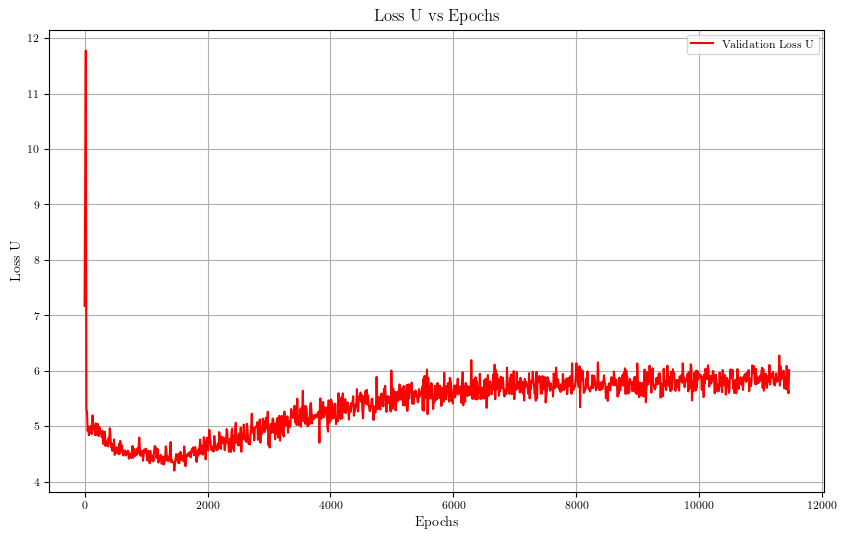

In [16]:
from pathlib import Path

nu = 0.01
rho = 1.0

N_u_train = 3800
N_u_val = 600
N_u_test = 600
#layers = [3, 20, 40, 40, 60, 60, 60, 50, 40, 30, 20, 3]
layers = [3, 500, 2000, 3000, 5000, 5000, 5000, 3000, 2000, 500, 60, 3]

data_path = Path('data/Flow.csv')

# data = scipy.io.loadmat(str(data_path))

data = np.loadtxt(str(data_path), delimiter=",", skiprows=1, ndmin=2, usecols=range(6))
# Assuming columns: t,x,y,u,v,p,dudx,dudy,dvdx,dvdy,dudt,dvdt,flow_type,sample_id
# print(np.shape(data))
data = data[5000:]
X_star = data[:, 0:3].copy()  # t, x, y
du_star = data[:, 6:12].copy()  # dudx, dudy, dvdx, dvdy, dudt, dvdt
u_star = data[:, 3:6].copy()  # u, v, p
t_data = data[:, 0:1].copy()
t_range = np.unique(t_data)
x_data = data[:, 1:2].copy()
x_range = np.unique(x_data)
y_data = data[:, 2:3].copy()
y_range = np.unique(y_data)

visualizations = []

#------
# for t in t_range:
#     row = data[data[:, 0] == t]
#     plot = {}
#     for x in x_range:
#         point = row[row[:, 1] == x]
#         for y in y_range:
#             measurements = point[point[:,2] == y]
#             if len(measurements) > 0:
#                 plot[(x.item(), y.item())] = measurements[:, 3:6].mean(axis=0)
#     visualizations.append((t.item(), plot))
#------


#Generate 30 visualizations, one for each time stamp and measurement value
# for vis in visualizations:
#     t, plot = vis
#     x_vals = []
#     y_vals = []
#     u_vals = []
#     v_vals = []
#     p_vals = []
#     for key, value in plot.items():
#         x, y = key
#         u, v, p = value
#         x_vals.append(x)
#         y_vals.append(y)
#         u_vals.append(u)
#         v_vals.append(v)
#         p_vals.append(p)
    
#     fig, axs = plt.subplots(1, 3, figsize=(18, 5))
#     sc1 = axs[0].scatter(x_vals, y_vals, c=u_vals, cmap='viridis')
#     axs[0].set_title(f'u at t={t:.2f}')
#     plt.colorbar(sc1, ax=axs[0])
    
#     sc2 = axs[1].scatter(x_vals, y_vals, c=v_vals, cmap='viridis')
#     axs[1].set_title(f'v at t={t:.2f}')
#     plt.colorbar(sc2, ax=axs[1])
    
#     sc3 = axs[2].scatter(x_vals, y_vals, c=p_vals, cmap='viridis')
#     axs[2].set_title(f'p at t={t:.2f}')
#     plt.colorbar(sc3, ax=axs[2])
    
#     plt.tight_layout()
#     plt.show()
#     # Optionally save the figure
#     # plt.savefig(f'visualization_t{t:.2f}.png')
#     plt.close()

            
#-----
# for vis in visualizations:
#     t, plot = vis
#     # Create meshgrid for x and y
#     x_vals = np.array(sorted(set([k[0] for k in plot.keys()])))
#     y_vals = np.array(sorted(set([k[1] for k in plot.keys()])))
#     X_grid, Y_grid = np.meshgrid(x_vals, y_vals)
#     U_grid = np.zeros_like(X_grid)
#     V_grid = np.zeros_like(X_grid)
#     P_grid = np.zeros_like(X_grid)
#     for i, x in enumerate(x_vals):
#         for j, y in enumerate(y_vals):
#             val = plot.get((x, y), None)
#             if val is not None:
#                 U_grid[j, i], V_grid[j, i], P_grid[j, i] = val
#             else:
#                 # Find neighbors for (x, y)
#                 neighbors = []
#                 for dx in [-1, 0, 1]:
#                     for dy in [-1, 0, 1]:
#                         if dx == 0 and dy == 0:
#                             continue
#                         ni = i + dx
#                         nj = j + dy
#                         if 0 <= ni < len(x_vals) and 0 <= nj < len(y_vals):
#                             neighbor_val = plot.get((x_vals[ni], y_vals[nj]), None)
#                             if neighbor_val is not None and not np.any(np.isnan(neighbor_val)):
#                                 neighbors.append(neighbor_val)
#                 if neighbors:
#                     avg = np.mean(neighbors, axis=0)
#                     U_grid[j, i], V_grid[j, i], P_grid[j, i] = avg
#                 else:
#                     U_grid[j, i], V_grid[j, i], P_grid[j, i] = np.nan, np.nan, np.nan

#     fig, axs = plt.subplots(1, 3, figsize=(18, 5))
#     im1 = axs[0].imshow(U_grid, extent=[x_vals.min(), x_vals.max(), y_vals.min(), y_vals.max()],
#                         origin='lower', aspect='auto', cmap='viridis')
#     axs[0].set_title(f'u at t={t:.2f}')
#     plt.colorbar(im1, ax=axs[0])

#     im2 = axs[1].imshow(V_grid, extent=[x_vals.min(), x_vals.max(), y_vals.min(), y_vals.max()],
#                         origin='lower', aspect='auto', cmap='viridis')
#     axs[1].set_title(f'v at t={t:.2f}')
#     plt.colorbar(im2, ax=axs[1])

#     im3 = axs[2].imshow(P_grid, extent=[x_vals.min(), x_vals.max(), y_vals.min(), y_vals.max()],
#                         origin='lower', aspect='auto', cmap='viridis')
#     axs[2].set_title(f'p at t={t:.2f}')
#     plt.colorbar(im3, ax=axs[2])

#     plt.tight_layout()
#     plt.show()
#     plt.close()
#-----
            

# u = data[:, 3:4].copy()
# v = data[:, 4:5].copy()
# p = data[:, 5:6].copy()

# t = data['t'].flatten()[:,None]
# x = data['x'].flatten()[:,None]
# Exact = np.real(data['usol']).T

# X, T = np.meshgrid(x,t)

# X_star = np.hstack((x_data, y_data, t_data))
# u_star = Exact.flatten()[:,None]              


# Load the log file
file_path = "both_sets.txt"

# Regex patterns
epoch_pattern = re.compile(r"Epoch:\s*(\d+)")
loss_u_pattern = re.compile(r"loss_u:\s*([0-9eE\+\-\.]+)")
val_loss_u_pattern = re.compile(r"val_loss_u:\s*([0-9eE\+\-\.]+)")

epochs, loss_u, val_loss_u = [], [], []

with open(file_path, "r") as f:
    for line in f:
        epoch_match = epoch_pattern.search(line)
        loss_u_match = loss_u_pattern.search(line)
        val_loss_u_match = val_loss_u_pattern.search(line)
        
        if epoch_match:
            epochs.append(int(epoch_match.group(1)))
        if loss_u_match:
            loss_u.append(float(loss_u_match.group(1)))
        if val_loss_u_match:
            val_loss_u.append(float(val_loss_u_match.group(1)))

# Ensure equal length for plotting
n = min(len(epochs), len(loss_u), len(val_loss_u))
epochs, loss_u, val_loss_u = epochs[:n], loss_u[:n], val_loss_u[:n]

# Default: plot val_loss_u
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_loss_u, label="Validation Loss U", color="red")

# If no significant decrease, plot loss_u instead
if val_loss_u and (min(val_loss_u) > 0.9 * val_loss_u[0]):  
    plt.clf()
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss_u, label="Training Loss U", color="blue")

plt.xlabel("Epochs")
plt.ylabel("Loss U")
plt.title("Loss U vs Epochs")
plt.legend()
plt.grid(True)
plt.show()



lb = X_star.min(0)
ub = X_star.max(0)

## Training on Non-noisy Data

In [34]:
# Training on non-noisy data
noise = 0.0            
# create training set
idx_train = np.random.choice(X_star.shape[0], N_u_train, replace=False)
remaining_idx = np.setdiff1d(np.arange(X_star.shape[0]), idx_train)
idx_val = np.random.choice(remaining_idx, N_u_val, replace=False)
remaining_idx = np.setdiff1d(remaining_idx, idx_val)
idx_test = np.random.choice(remaining_idx, N_u_test, replace=False)
X_u_train = X_star[idx_train,:]
du_train = du_star[idx_train,:]
u_train = u_star[idx_train,:]
X_u_val = X_star[idx_val,:]
du_val = du_star[idx_val,:]
u_val = u_star[idx_val,:]
X_u_test = X_star[idx_test,:]
du_test = du_star[idx_test,:]
u_test = u_star[idx_test,:]



In [ ]:
# training
#hyperparameters grid search
optimal_params = {
    'lr': 0.01,
    'weight_decay': 0.01,
    'incomp_weight': 0.2,
    'deriv_weight': 0.2
}
best_error = float('inf')
for lrinput in [1.0, 0.1, 0.01]:
    for weight_decayinput in [0.1, 0.01, 0]:
        for incomp_weight in [0.5, 0.35, 0.2, 0.1, 0.05]:
            for deriv_weight in [0.5, 0.35, 0.2, 0.1, 0.05]:
                print(f"Training with learning rate: {lrinput}, weight decay: {weight_decayinput}, incomp weight: {incomp_weight}, deriv weight: {deriv_weight}")
                model = PhysicsInformedNN(X_u_train, u_train, du_train, X_u_val, u_val, du_val, 
                                          layers, lb, ub, nu, rho, lrinput, weight_decayinput, 
                                          incomp_weight, deriv_weight)
                model.train(500)
                t_eval = torch.tensor(X_u_test[:, 0:1], requires_grad=True, dtype=torch.float32).to(device)
                x_eval = torch.tensor(X_u_test[:, 1:2], requires_grad=True, dtype=torch.float32).to(device)
                y_eval = torch.tensor(X_u_test[:, 2:3], requires_grad=True, dtype=torch.float32).to(device)
                u_eval = torch.tensor(u_test, dtype=torch.float32).to(device)

                model.dnn.eval()
                # with torch.no_grad():
                u_out = model.net_u(t_eval, x_eval, y_eval)
                # f_out = model.net_f(t_eval, x_eval, y_eval)

                u_pred = u_out.detach().cpu().numpy()
                # f_pred = f_out.detach().cpu().numpy()
                u_real = u_eval.detach().cpu().numpy()

                error_u = np.linalg.norm(u_real-u_pred,2)/np.linalg.norm(u_real,2)
                if error_u < best_error:
                    best_error = error_u
                    optimal_params['lr'] = lrinput
                    optimal_params['weight_decay'] = weight_decayinput
                    optimal_params['incomp_weight'] = incomp_weight
                    optimal_params['deriv_weight'] = deriv_weight
                    print(f"New best error: {best_error:.6f} with params: {optimal_params}")



# Save the model weights
weights_path = Path('model_weights.pth')
save_model_weights(model, weights_path)

Training with learning rate: 1.0, weight decay: 0.1, incomp weight: 0.5, deriv weight: 0.5


KeyboardInterrupt: 

In [1]:
# Load the model weights
model = PhysicsInformedNN(X_u_train, u_train, du_train, X_u_val, u_val, du_val, layers, lb, ub, nu, rho)
weights_path = Path('model_weights_2000.pth')
load_model_weights(model, weights_path)

NameError: name 'PhysicsInformedNN' is not defined

In [36]:
# evaluations
# u_pred, f_pred = model.predict(X_star)
t_eval = torch.tensor(X_u_test[:, 0:1], requires_grad=True, dtype=torch.float32).to(device)
x_eval = torch.tensor(X_u_test[:, 1:2], requires_grad=True, dtype=torch.float32).to(device)
y_eval = torch.tensor(X_u_test[:, 2:3], requires_grad=True, dtype=torch.float32).to(device)
u_eval = torch.tensor(u_test, dtype=torch.float32).to(device)

model.dnn.eval()
# with torch.no_grad():
u_out = model.net_u(t_eval, x_eval, y_eval)
# f_out = model.net_f(t_eval, x_eval, y_eval)

u_pred = u_out.detach().cpu().numpy()
# f_pred = f_out.detach().cpu().numpy()
u_real = u_eval.detach().cpu().numpy()
print("u pred head:", u_pred[:5], "u real head:", u_real[:5])

error_u = np.linalg.norm(u_real-u_pred,2)/np.linalg.norm(u_real,2)
# error_f = np.linalg.norm(f_pred,2)

# U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

# lambda_1_value = model.lambda_1.detach().cpu().numpy()
# lambda_2_value = model.lambda_2.detach().cpu().numpy()
# lambda_2_value = np.exp(lambda_2_value)

# error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
# error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print(f'Error u: {error_u:.6e}')
# print(f'Error f: {error_f:.6e}')
# print(f'Error l1: {error_lambda_1:.5f}%')
# print(f'Error l2: {error_lambda_2:.5f}%')

u pred head: [[ 9.0973878e-01 -2.1298956e-03 -2.1513939e-02]
 [ 4.0519273e-01  7.0661902e-03 -2.8914094e-02]
 [-2.7081490e-02  7.7618118e-03 -2.8791158e+00]
 [ 5.0005019e-03 -5.5040037e-03 -1.3193150e+00]
 [ 3.8192984e-01 -4.3110944e-02 -5.0126237e-01]] u real head: [[ 8.8888890e-01  1.3033141e-04  0.0000000e+00]
 [ 3.9506173e-01 -2.0906336e-04  0.0000000e+00]
 [-1.1947947e-05  2.7479380e-03 -2.9473772e+00]
 [-1.1454685e-02  2.1231587e-03 -1.2542071e+00]
 [ 3.8270560e-01  1.2946650e-03 -8.3759212e-01]]
Error u: 5.444289e-01


## Training on Noisy Data

In [ ]:
# Training on noisy data
noise = 0.01    
# create training set
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

# training
# model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(10000)

Epoch: 0, Training Loss: 1.480349e-01, loss_u: 1.47164e-01, loss_f: 8.70604e-04
Validation Loss: 2.021559e+00, val_loss_u: 5.10673e-01, val_loss_f: 1.51089e+00
Epoch: 100, Training Loss: 1.494272e-01, loss_u: 1.48337e-01, loss_f: 1.08979e-03
Validation Loss: 1.403761e-01, val_loss_u: 1.39272e-01, val_loss_f: 1.10404e-03
Epoch: 200, Training Loss: 1.481786e-01, loss_u: 1.47437e-01, loss_f: 7.41531e-04
Validation Loss: 1.389109e-01, val_loss_u: 1.38137e-01, val_loss_f: 7.73716e-04
Epoch: 300, Training Loss: 1.479491e-01, loss_u: 1.47278e-01, loss_f: 6.71531e-04
Validation Loss: 1.384970e-01, val_loss_u: 1.37803e-01, val_loss_f: 6.93456e-04
Epoch: 400, Training Loss: 1.478371e-01, loss_u: 1.47209e-01, loss_f: 6.28313e-04
Validation Loss: 1.382855e-01, val_loss_u: 1.37642e-01, val_loss_f: 6.43242e-04
Epoch: 500, Training Loss: 1.477467e-01, loss_u: 1.47154e-01, loss_f: 5.92406e-04
Validation Loss: 1.381506e-01, val_loss_u: 1.37547e-01, val_loss_f: 6.03306e-04
Epoch: 600, Training Loss: 1.5

KeyboardInterrupt: 

## Visualizations

findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because

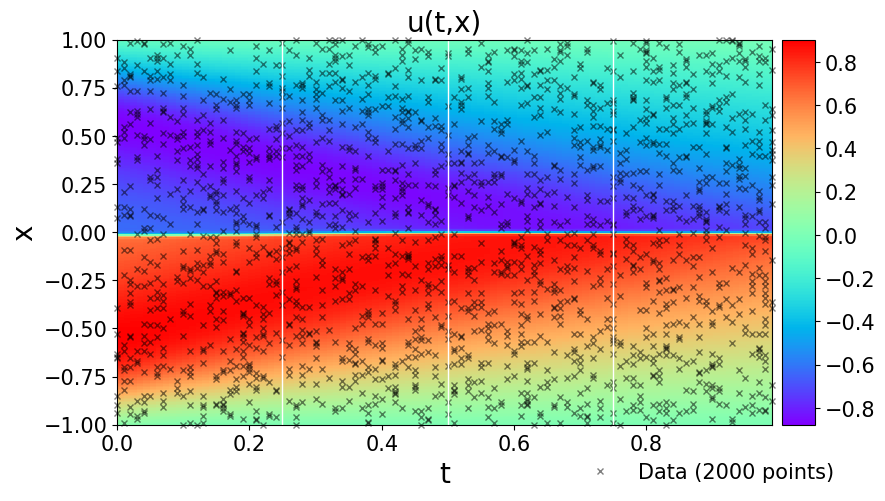

In [ ]:

""" The aesthetic setting has changed. """
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False  # Disable LaTeX rendering

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('t', size=20)
ax.set_ylabel('x', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('u(t,x)', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because

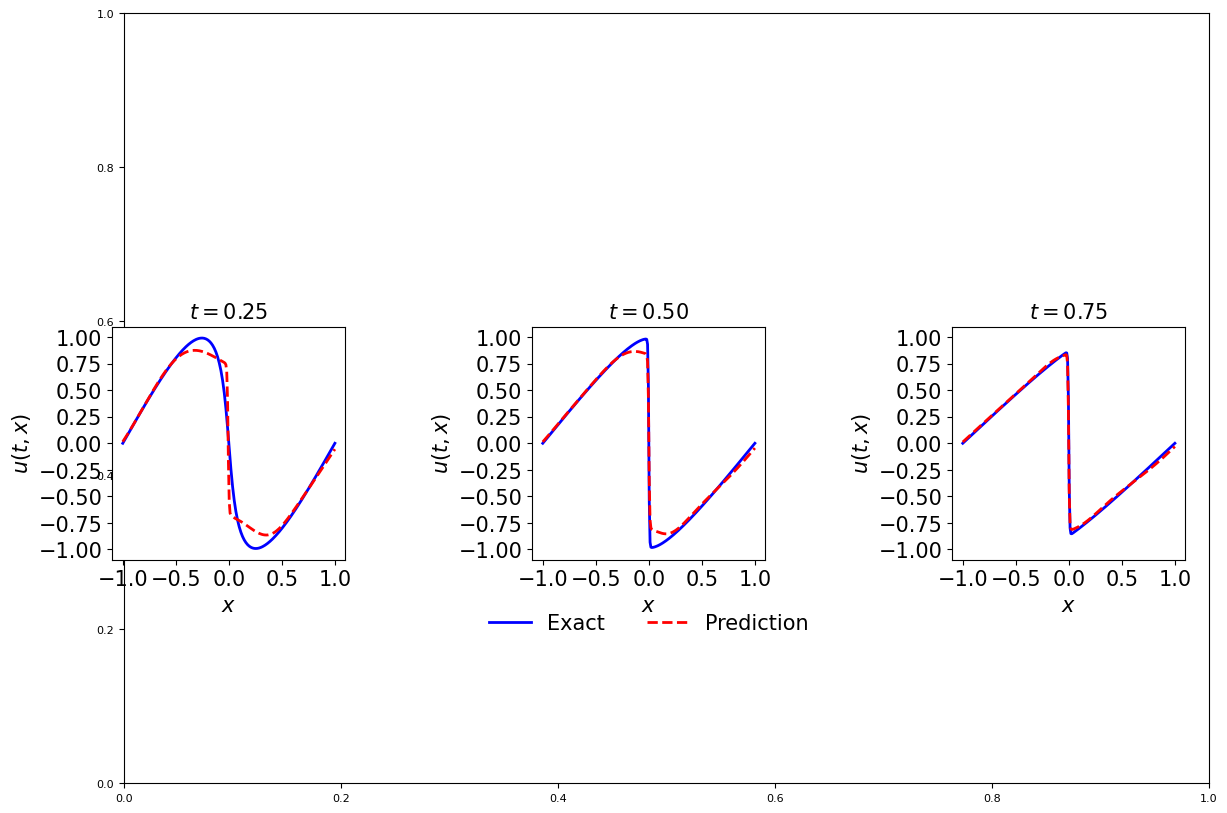

In [ ]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

In [ ]:
# evaluations (noisy)
u_pred, f_pred = model.predict(X_star)

lambda_1_value_noisy = model.lambda_1.detach().cpu().numpy()
lambda_2_value_noisy = model.lambda_2.detach().cpu().numpy()
lambda_2_value_noisy = np.exp(lambda_2_value_noisy)

error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0) * 100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - nu) / nu * 100

print(f'Error u: {error_u:.6e}')
print(f'Error l1: {error_lambda_1_noisy:.5f}%')
print(f'Error l2: {error_lambda_2_noisy:.5f}%')

Error u: 1.525990e-03
Error l1: 0.15550%
Error l2: 0.61871%


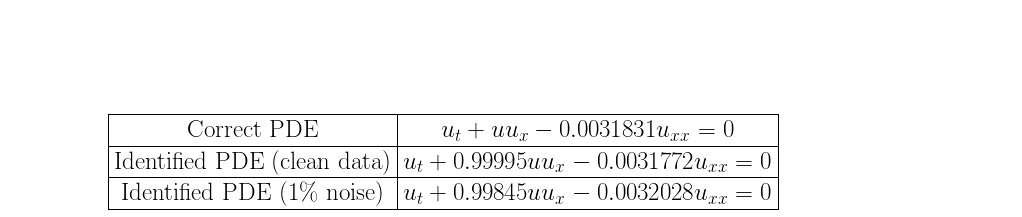

In [ ]:
####### Row 3: Identified PDE ##################    

fig = plt.figure(figsize=(14, 10))

gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=0.25, bottom=0, left=0.0, right=1.0, wspace=0.0)

ax = plt.subplot(gs2[:, :])
ax.axis('off')

s1 = r'$\begin{tabular}{ |c|c| }  \hline Correct PDE & $u_t + u u_x - 0.0031831 u_{xx} = 0$ \\  \hline Identified PDE (clean data) & '
s2 = r'$u_t + %.5f u u_x - %.7f u_{xx} = 0$ \\  \hline ' % (lambda_1_value, lambda_2_value)
s3 = r'Identified PDE (1\% noise) & '
s4 = r'$u_t + %.5f u u_x - %.7f u_{xx} = 0$  \\  \hline ' % (lambda_1_value_noisy, lambda_2_value_noisy)
s5 = r'\end{tabular}$'
s = s1+s2+s3+s4+s5
ax.text(0.1, 0.1, s, size=25)

plt.show()